<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Данные успешно загружены из URL.
Размер данных: (10000, 30)
Пример данных:
       debts   bequests  wife  husband  sons  daughters  father  mother  \
0   89083.21   47843.65     1        0     1          2       0       0   
1   89149.37  243374.33     1        0     5          5       1       0   
2     648.46   17774.84     0        1     3          1       0       0   
3   23549.63  165834.40     0        0     3          4       1       1   
4  199933.12  177838.94     1        0     5          4       1       0   

   brothers  sisters  ...  debts_standard  bequests_standard  wife_standard  \
0         3        3  ...        0.436273          -0.436317       1.273816   
1         0        1  ...        0.437485           2.607576       1.273816   
2         3        0  ...       -1.184573          -0.904409      -0.785043   
3         2        2  ...       -0.764837           1.400485      -0.785043   
4         2        3  ...        2.467948           1.587364       1.273816   


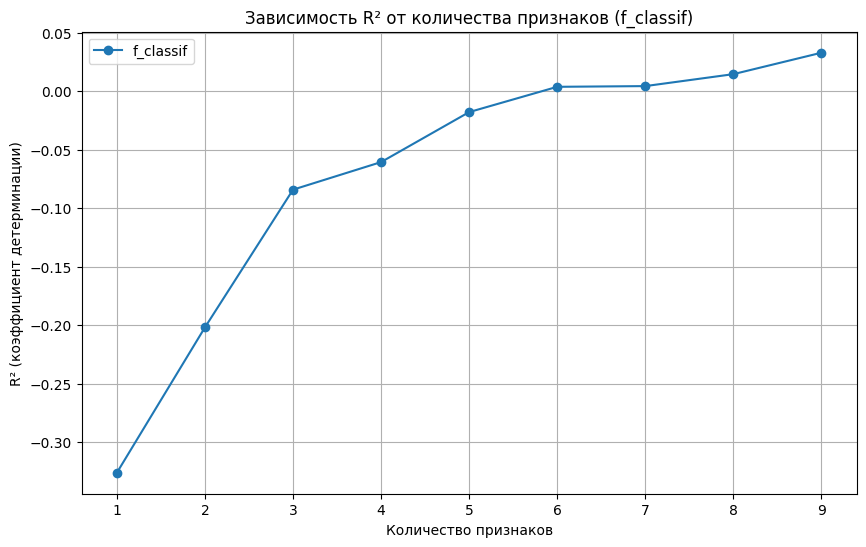

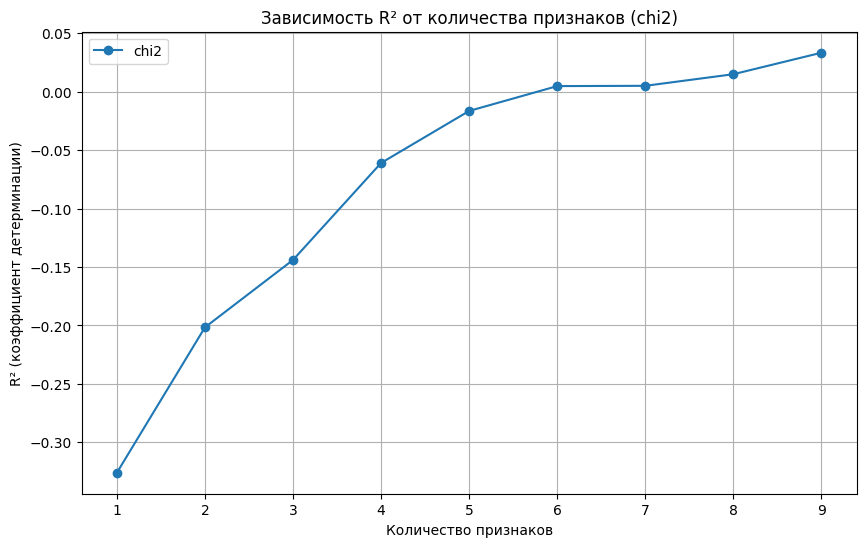

   Количество признаков  R² (f_classif)  \
0                     1       -0.325978   
1                     2       -0.201772   
2                     3       -0.084075   
3                     4       -0.060512   
4                     5       -0.017783   
5                     6        0.003821   
6                     7        0.004427   
7                     8        0.014637   
8                     9        0.032952   

                      Выбранные признаки (f_classif)  R² (chi2)  \
0                                           bequests  -0.325977   
1                                 bequests, brothers  -0.201615   
2                      bequests, daughters, brothers  -0.143937   
3              bequests, daughters, father, brothers  -0.060970   
4        bequests, sons, daughters, father, brothers  -0.016457   
5  bequests, sons, daughters, father, mother, bro...   0.004790   
6  bequests, husband, sons, daughters, father, mo...   0.005031   
7  bequests, wife, husband, sons,

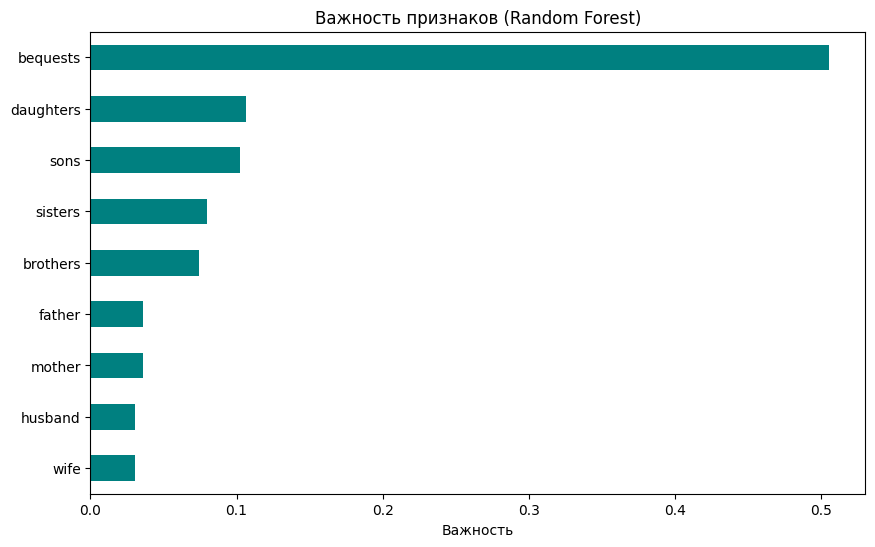

In [1]:
#---------------------------------------------------------- Лабораторная работа №4:-------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ------------------- Функция загрузки данных -------------------

def load_data(url):
    try:
        df = pd.read_csv(url)
        print("Данные успешно загружены из URL.")
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        from google.colab import files
        uploaded = files.upload()
        df = pd.read_csv(next(iter(uploaded)))
        print("Данные успешно загружены из локального файла.")
    return df

url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
df = load_data(url)

# ------------------- Первичный осмотр данных -------------------

print(f"Размер данных: {df.shape}")
print("Пример данных:")
print(df.head())

# ------------------- Выбор признаков и заполнение пропусков -------------------

feature_columns = [
    'debts', 'bequests', 'wife', 'husband', 'sons', 'daughters',
    'father', 'mother', 'brothers', 'sisters'
]

df_selected = df[feature_columns].copy()
df_selected.fillna(df_selected.median(), inplace=True)

# ------------------- Создание бинарного целевого признака -------------------

median_debts = df_selected['debts'].median()
df_selected['high_debts'] = (df_selected['debts'] >= median_debts).astype(int)

# ------------------- Формирование X и y -------------------

X = df_selected.drop(columns=['high_debts', 'debts'])
y = df_selected['high_debts']

feature_names = X.columns.tolist()

# ------------------- Разбиение на обучающую и тестовую выборки -------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------- Масштабирование признаков -------------------

scaler_std = StandardScaler()
X_train_scaled = scaler_std.fit_transform(X_train)
X_test_scaled = scaler_std.transform(X_test)

scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

# ------------------- Функция оценки отбора признаков -------------------

def evaluate_feature_selection(score_func, score_func_name,
                               X_train, X_test, y_train, y_test, feature_names, max_features=10):
    feature_counts = list(range(1, min(X_train.shape[1], max_features) + 1))
    scores = []
    selected_features_dict = {}

    for k in feature_counts:
        selector = SelectKBest(score_func, k=k)
        X_train_sel = selector.fit_transform(X_train, y_train)
        X_test_sel = selector.transform(X_test)

        model = RandomForestRegressor(random_state=42)
        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_test_sel)

        r2 = r2_score(y_test, y_pred)
        scores.append(r2)

        selected = [f for f, s in zip(feature_names, selector.get_support()) if s]
        selected_features_dict[k] = selected

    plt.figure(figsize=(10,6))
    plt.plot(feature_counts, scores, marker='o', label=score_func_name)
    plt.xlabel('Количество признаков')
    plt.ylabel('R² (коэффициент детерминации)')
    plt.title(f'Зависимость R² от количества признаков ({score_func_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return feature_counts, scores, selected_features_dict

# ------------------- Оценка отбора признаков для f_classif -------------------

fc_counts, fc_scores, fc_features = evaluate_feature_selection(
    f_classif, 'f_classif',
    X_train_scaled, X_test_scaled, y_train, y_test, feature_names
)

# ------------------- Оценка отбора признаков для chi2 -------------------

chi_counts, chi_scores, chi_features = evaluate_feature_selection(
    chi2, 'chi2',
    X_train_minmax, X_test_minmax, y_train, y_test, feature_names
)

# ------------------- Формирование итоговой таблицы результатов -------------------

results_df = pd.DataFrame({
    'Количество признаков': fc_counts,
    'R² (f_classif)': fc_scores,
    'Выбранные признаки (f_classif)': [", ".join(fc_features[k]) for k in fc_counts],
    'R² (chi2)': chi_scores,
    'Выбранные признаки (chi2)': [", ".join(chi_features[k]) for k in chi_counts],
})

print(results_df.head(10))
results_df.to_csv('feature_selection_results.csv', index=False)
print("Результаты сохранены в 'feature_selection_results.csv'")

# ------------------- Обучение Random Forest на всех признаках -------------------

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_scaled, y_train)

importances = pd.Series(model_rf.feature_importances_, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10,6))
importances.plot(kind='barh', color='teal')
plt.title('Важность признаков (Random Forest)')
plt.xlabel('Важность')
plt.show()
